In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [39]:
from tabulate import tabulate

def visualize(df):
    print(f"Data Frame has {df.shape[0]} rows and {df.shape[1]} rows\n")
    print("These are the column names:")
    print(df.columns)

    information = []
    counter = 0

    for column in df.columns:
        information.append([f"{counter}: {column}", f"{df[column].nunique()} unique values", f"{df[column].isna().sum()} are NaN", f"Type: {df[column].dtype}"])
        counter += 1

    print(tabulate(information, headers=['Column', 'Values', 'NaN', 'Type']))

    print("\n")

    counter = 0
    for column in df.columns:
        print(f"{counter}: {column} has {df[column].nunique()} unique values. {df[column].isna().sum()} are NaN.")
        print(f"It's {df[column].dtype}. These are the unique values:")
        print(f"{df[column].unique()}\n")
        counter += 1

In [24]:
df = pd.read_csv("telecom_users.csv")

In [40]:
visualize(df)

Data Frame has 5986 rows and 20 rows

These are the column names:
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Column                Values              NaN        Type
--------------------  ------------------  ---------  -------------
0: gender             2 unique values     0 are NaN  Type: object
1: SeniorCitizen      2 unique values     0 are NaN  Type: object
2: Partner            2 unique values     0 are NaN  Type: object
3: Dependents         2 unique values     0 are NaN  Type: object
4: tenure             73 unique values    0 are NaN  Type: int64
5: PhoneService       2 unique values     0 are NaN  Type: object
6: MultipleLines      3 unique values     0 are

## Data Cleaning

In [26]:
# Looking at the data it seems like then "TotalCharges" has 10 empty cells that are not even NaN
#    So we will fill these with 0
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0)

# We also convert this column to float64
df['TotalCharges'] = df['TotalCharges'].astype(np.float64)

# We drop "Unnamed: 0" and "customerID", since they are not needed to understand the data
df.drop(['Unnamed: 0', 'customerID'], axis=1, inplace=True)

# Convert Senior boolean to yes or no
df['SeniorCitizen'].replace(to_replace=1, value='Yes', inplace=True)
df['SeniorCitizen'].replace(to_replace=0,  value='No', inplace=True)

# Convert Churn boolean to (0,1)
columns = ['Churn']
for columns in columns:
    df[columns].replace(to_replace='Yes', value=1, inplace=True)
    df[columns].replace(to_replace='No',  value=0, inplace=True)

## Exploratory Analysis

### Churn Percentage

73.49% of customers didn't Churn (4399 of 5986)
26.51% of customers Churned (1587 of 5986)


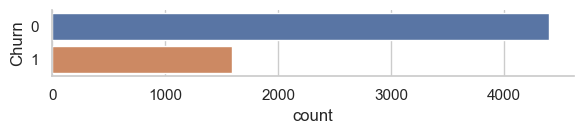

In [27]:
churn_count = df['Churn'].value_counts()
print(f"{(churn_count[0]/len(df))*100:0.2f}% of customers didn't Churn ({churn_count[0]} of {len(df)})")
print(f"{(churn_count[1]/len(df))*100:0.2f}% of customers Churned ({churn_count[1]} of {len(df)})")

ax = sns.catplot(y="Churn", kind="count", data=df, height=1.5, aspect=4, orient='h');

### Churn Correlation

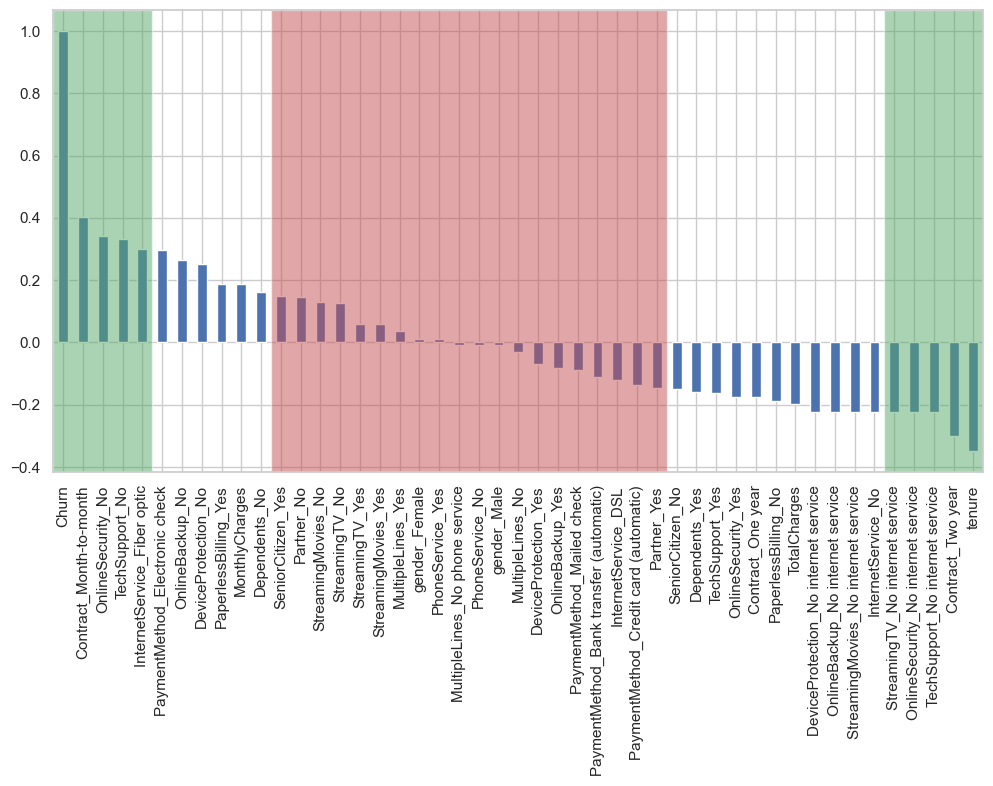

In [28]:
df_dummies = pd.get_dummies(df)

plt.figure(figsize=(12,6))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.axvspan(-0.5, 4.5, facecolor='g', alpha=0.5)
plt.axvspan(10.5, 30.5, facecolor='r', alpha=0.5)
plt.axvspan(41.5, 46.5, facecolor='g', alpha=0.5);


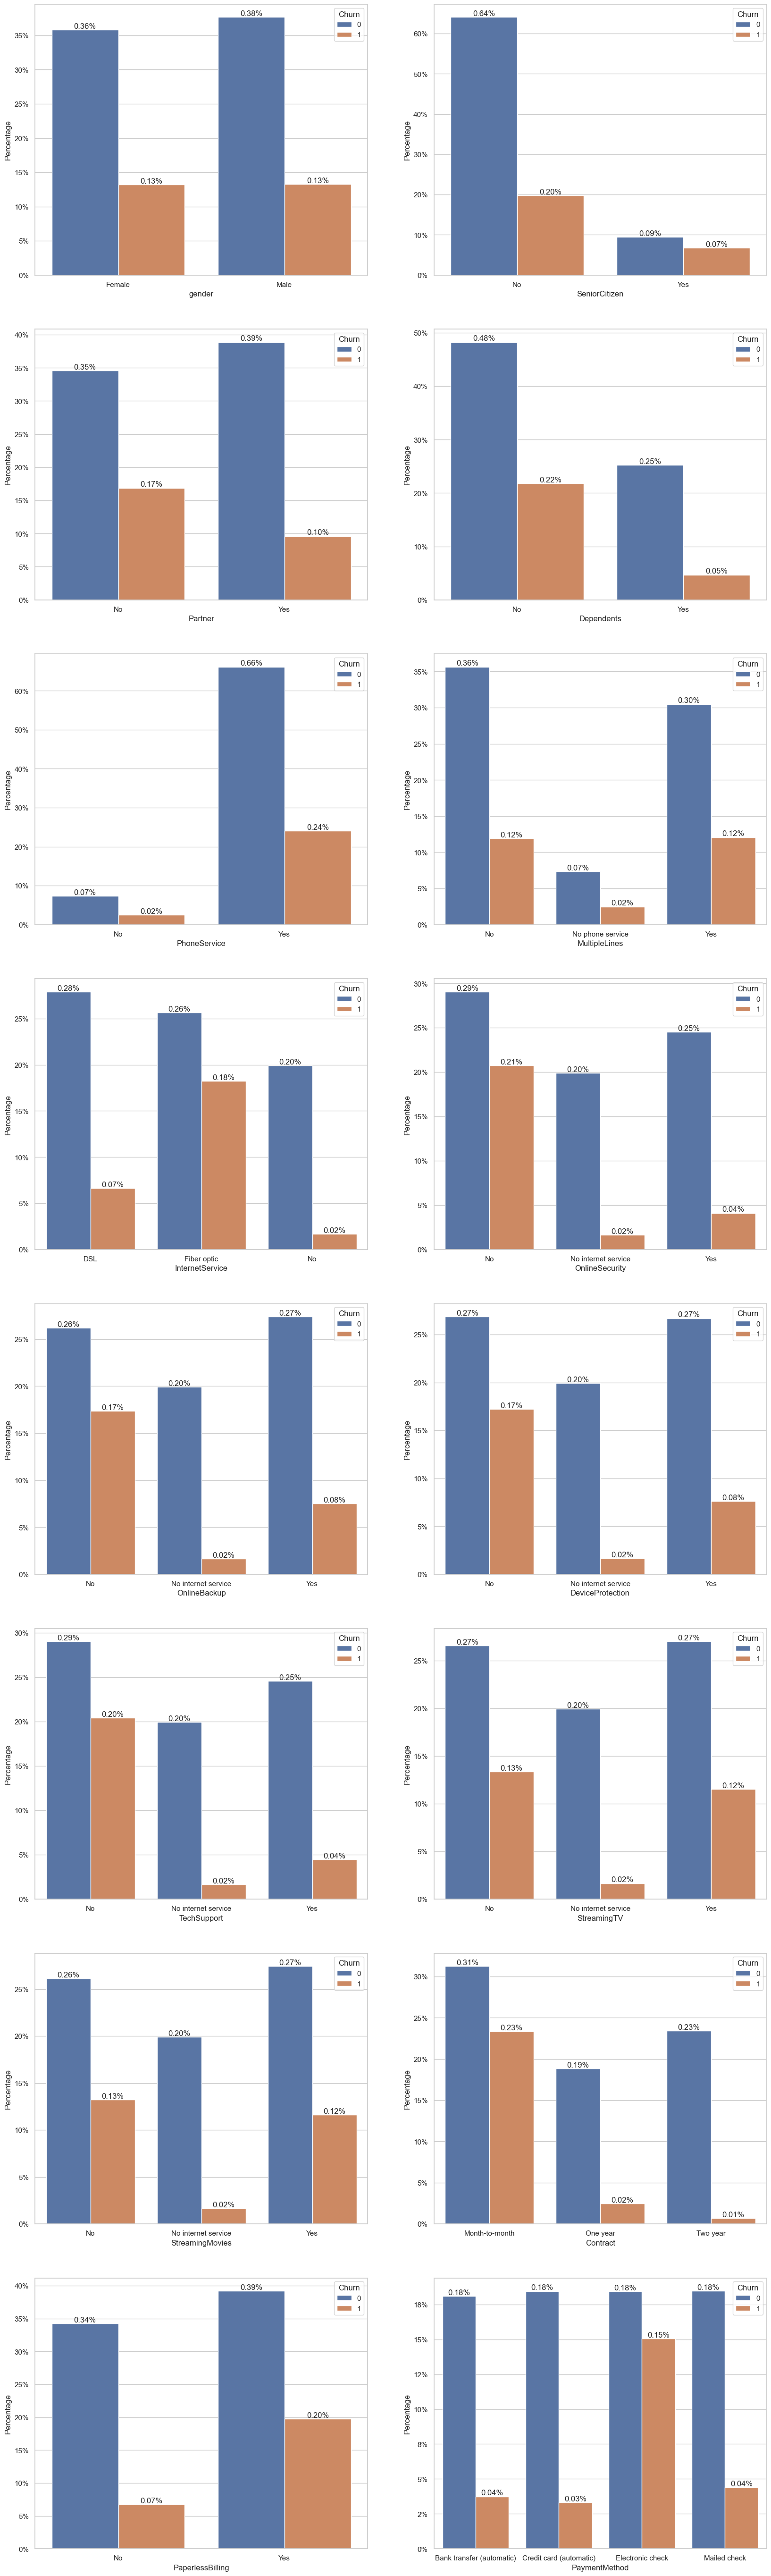

In [32]:
import warnings
warnings.simplefilter("ignore", UserWarning)

def group(target, df=df, count='Churn'):
    group = df.groupby(target)[count].value_counts().to_frame()
    group = group.rename({"Churn": "Percentage"}, axis=1).reset_index()
    group['Percentage'] = group['Percentage']/len(df)
    return group

plot_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                'Contract', 'PaperlessBilling', 'PaymentMethod']

fig, axis = plt.subplots(len(plot_columns)//2, 2, figsize=(20,70))

label_format = '{:,.0f}'

for count, column in enumerate(plot_columns):
    c = 0 if count % 2 == 0 else 1
    ax = sns.barplot(x=column, y='Percentage', hue='Churn', data=group(column), orient='v', ax=axis[count//2][c])
    ax.set_yticklabels([f"{y:,.0%}" for y in ax.get_yticks()])
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%')

plt.show();

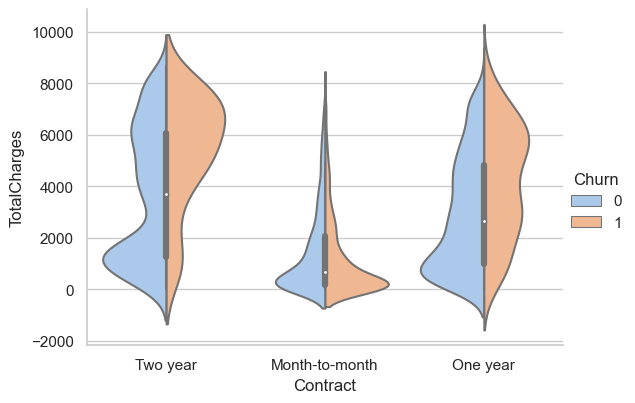

In [33]:
ax = sns.catplot(x="Contract", y="TotalCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

### Heatmap

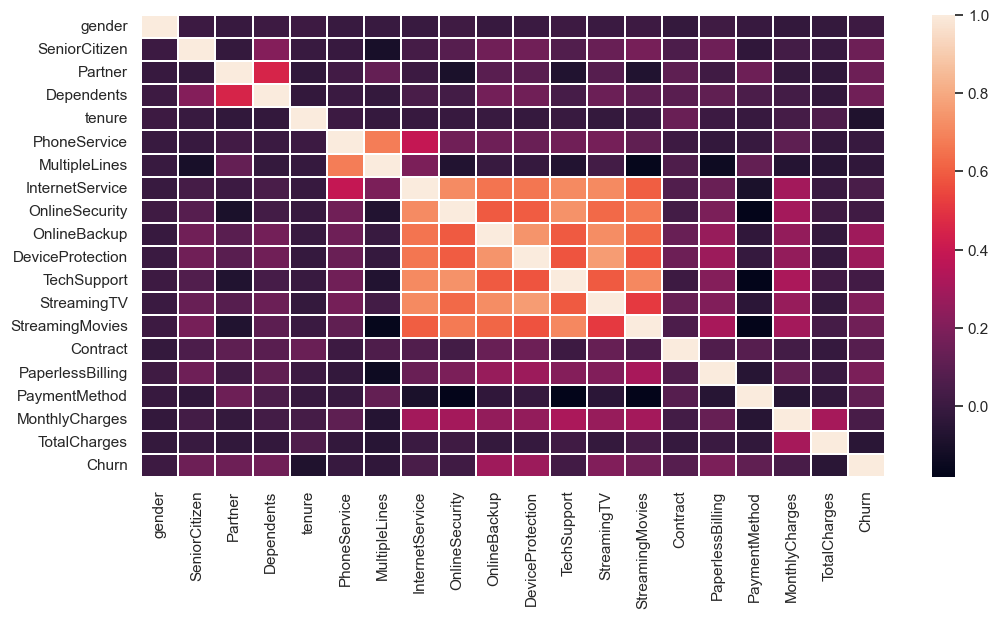

In [34]:
plt.figure(figsize=(12, 6))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2)

## Simple Feauture Importance

In [35]:
from sklearn.ensemble import RandomForestClassifier

params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}

# One-hot encode
df_dum = pd.get_dummies(df)

# Drop redundant columns
drop = ['Churn', 'gender_Female']

x = df_dum.drop(drop, axis=1)
y = df_dum['Churn'] 

# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)


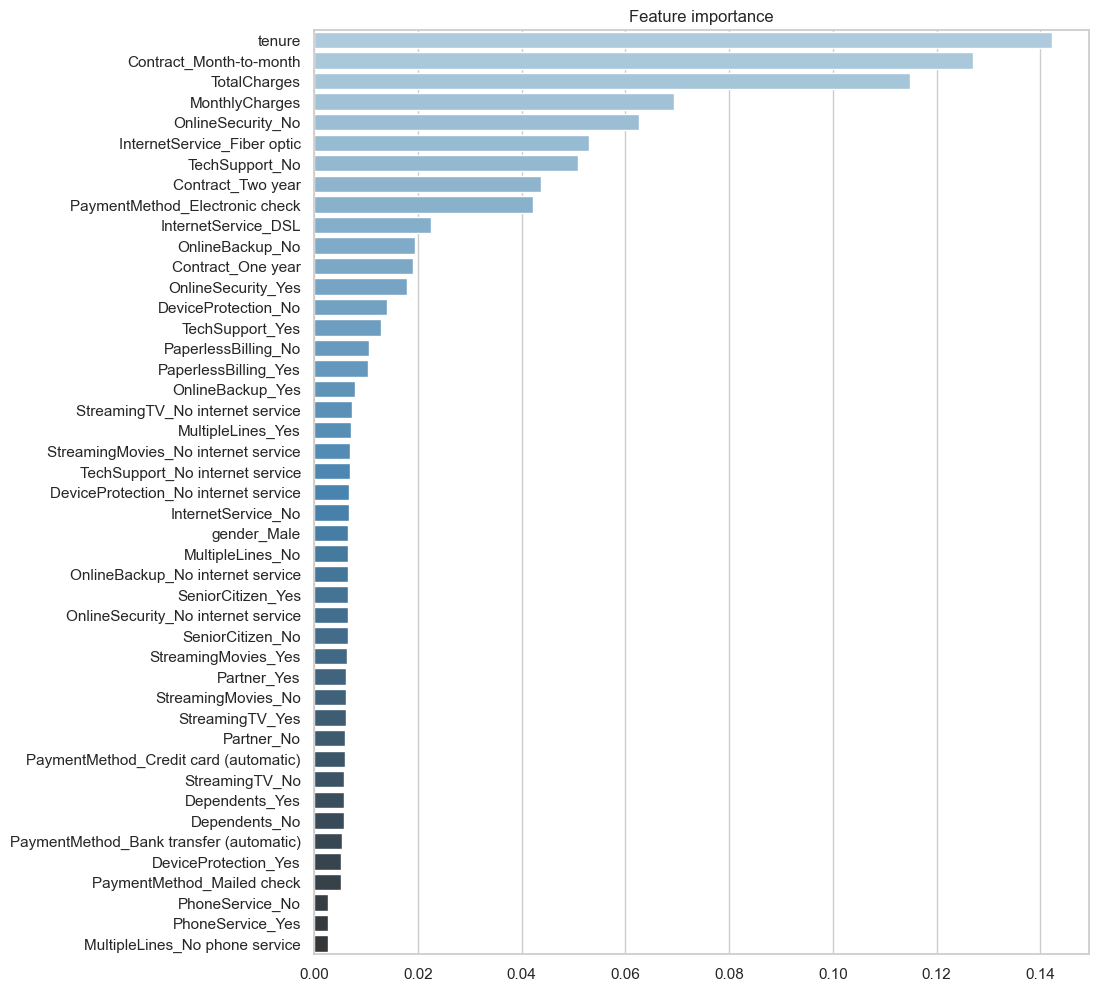

In [36]:
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
